In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q pyomo

In [ ]:
%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

In [ ]:
import pyomo
from functools import total_ordering
from re import sub
from pyomo.environ import *
from pyomo.opt import SolverStatus, TerminationCondition

In [ ]:
import numpy as np
import time
import math
from itertools import product

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.cbook

In [ ]:
import pickle
pwd = 'please write your path'
with open(os.path.join(pwd, 'logistic_07_09_030323.pkl'), 'rb') as f:
    data = pickle.load(f)

In [ ]:
dir_path = 'please write your path'
print(os.path.exists(dir_path))

True


### Import Data

In [ ]:
print(data.keys())

dict_keys(['market_size', 'b', 'k', 'avg_dist', 'avg_time', 'uber', 'avg_price', 'avg_price_per_dist'])


In [ ]:
L = data['market_size'].keys()
n = len(L)
T = 120

In [ ]:
market, b, k, d, t = {}, {}, {}, {}, {}
num = {}
uber_m = 0
service_time_uber = []
for i in L:
  for j in L:
    market[i,j] = data['market_size'].loc[i,j] if i != j else 0
    b[i,j] = data['b'].loc[i,j] if i != j else 0
    k[i,j] = data['k'].loc[i,j] if i != j else 0
    d[i,j] = data['avg_dist'].loc[i,j]
    t[i,j] = data['avg_time'].loc[i,j]/T
    uber_m += data['uber']['num'].loc[i,j] if i != j else 0
    num[i,j] = data['uber']['num'].loc[i,j] if i != j else 0
    service_time_uber.append(data['uber']['sum_service'].loc[i,j] if i != j else 0)

In [ ]:
# supply \approx demand
m = round(sum(service_time_uber)/T)
print('number of cars', m)
print('total market size', sum(market.values()))

number of cars 1548
total market size 16804


In [ ]:
param = {'market': market, 'b': b, 'k': k, 'd': d, 'n': n, 'm': m, 't': t, 'delta': m}

In [ ]:
sum_p = data['uber']['sum_p']
sum_dist = data['uber']['sum_dist']
prices_per_dist = data['uber']['prices_per_dist']

ppm, ppm2 = {}, {}
for i in range(1, 11):
  for j in range(1, 11):
    if i != j:
      ppm[i,j] = sum_p.loc[i,j]/sum_dist.loc[i,j]
      ppm2[i,j] = sum(prices_per_dist[i,j])/len(prices_per_dist[i,j])

### Buzen's Algorithm

In [ ]:
def modified_buzens_algorithm(N, M, w_ij, tau):
  Z = [1] + [0 for _ in range(M)]
  Z_prev = [1] + [0 for _ in range(M)]

  for n in range(1, N+1):
    if n == 1:
      for m in range(1, M+1):
        Z[m] = w_ij[n-1, n-1] * Z[m-1]
    else:
      tau_n_by_fact = [pow(tau[n-1], j)/math.factorial(j) if j<100 else 0 for j in range(M+1)]
      for m in range(1, M+1):
        Z[m] = sum([tau_n_by_fact[j] * Z_prev[m-j] for j in range(m+1)]) + w_ij[n-1, n-1] * Z[m-1]
        if Z[m] > 1e23:
          Z = [Z_i/1e23 for Z_i in Z]
          Z_prev = [Z_i/1e23 for Z_i in Z_prev]
    Z_prev = Z.copy()
  return Z[M-1] / Z[M]


import numpy as np
def get_r(Lambda, n):
  # convert dictionary to numpy array
  # inflow == outflow
  lambda_i_ = np.sum(Lambda, axis = 1) # sum_{j} lambda_ij
  A = Lambda.T - np.diag(lambda_i_)

  # Perform SVD on A
  U, s, Vt = np.linalg.svd(A)

  # Find the null space of A
  null_space = Vt.T[:, np.isclose(s, 0)]

  # Print a non-zero solution
  if null_space.size == 0:
      print("No non-zero solutions.")
  else:
      solution = null_space[:, 0]
      solution = np.abs(solution).tolist()
  pos = [element for element in solution if element > 0]
  return pos

## Example
Lambda = np.asarray([[0, 1/2,],[1/2, 0]])
r = get_r(Lambda, 2)
print(type(r))
print(r[0], r[1])

<class 'list'>
0.7071067811865475 0.7071067811865476


In [ ]:
def get_w(Lambda, n, t):
  r = [ri * 1/2 for ri in get_r(Lambda, n)]
  w_ij = np.zeros((n,n))
  for i in range(n):
    for j in range(n):
      if i != j:
        w_ij[i,j]=r[i]*Lambda[i,j]
      else:
        w_ij[i,j]=r[i]

  Norm = np.max([w_ij[i,i] for i in range(n)])
  w_ij = w_ij/Norm
  r = r/Norm

  tau = np.zeros(n+1)
  for i in range(1, n+1):
    g1 = [idx1 for idx1 in range(1,i+1)]
    g2 = [idx2 for idx2 in range(i+1,min(i+2,n+1))]
    tau[i] = sum([t[i2,j2]*w_ij[i2-1,j2-1] + t[j2,i2]*w_ij[j2-1,i2-1] for (i2,j2) in list(product(g1, g2))])
  return r, w_ij, tau

In [ ]:
def get_pi(N, M, r, w_ij, tau):
  pi = {}
  Z_ratio = modified_buzens_algorithm(n, m, w_ij, tau) #buzens_algorithm(N, M, r_i)
  for loc in range(len(r)):
    pi[loc+1] = Z_ratio * r[loc]
  return pi

In [ ]:
def get_pi_for_balanced(market, N, M, q, t):
  wl = sum([market[key]*q[key]*t[key] for key in market.keys() if key[0] != key[1]])
  pi = 0
  for m in range(1,M+1):
    pi = M/(M+N-1+(1-pi)*wl)
  return {i: pi for i in range(1,N+1)}

In [ ]:
def true_value(param, q, balanced=True):
  market, b, n, m, d, t, k, b = param['market'], param['b'], param['n'], param['m'], param['d'], param['t'], param['k'], param['b']

  Lambda = np.zeros((n,n))
  for i in range(n):
    for j in range(n):
      if i != j:
        Lambda[i,j] = market[i+1,j+1] * q[i+1, j+1]
      else:
        Lambda[i,j] = 0

  if balanced:
    pi = get_pi_for_balanced(market, n, m, q, t)
  else:
    r, w_ij, tau = get_w(Lambda, n, t)
    pi = get_pi(n, m, r, w_ij, tau)

  L = [i for i in range(1, n+1)]
  p = {}
  for i in L:
    for j in L:
      if i != j:
        p[i,j] = max(np.log(k[i,j]*(1-q[i,j])/q[i,j])/b[i,j], 0)
      else:
        p[i,j] = 0

  revenue = sum([market[i,j]*p[i,j]*q[i,j]*pi[i]*d[i,j] if i != j else 0 for i in L for j in L])

  sur, access, total_surplus = {}, {}, 0
  for i in L:
    for j in L:
      if i != j:
        sur[i,j] = -1/b[i,j]*np.log(1-q[i,j])*pi[i] * d[i,j] # np.log(1+k[i,j]*np.exp(-b[i,j]*p[i,j])) * pi[i] / b[i,j] * d[i,j]
        access[i,j] = q[i,j] * pi[i]
        total_surplus += market[i,j] * sur[i,j]
      else:
        sur[i,j] = 0
        access[i,j] = 0

  return revenue, {'s': sur, 'ts': total_surplus, 'r': pi}, p, access

### Approximation Model

In [ ]:
from functools import total_ordering
from re import sub
from pyomo.environ import *

def approx_model(param, solver = 'ipopt', fairness='Price', T=120, resource_constraint=True):
  market, b, k, n, m, d, t = param['market'], param['b'], param['k'], param['n'], param['m'], param['d'], param['t']

  L = [i for i in range(1,n+1)]

  model = ConcreteModel()

  ### Define the decision
  model.q = Var(L, L, domain = NonNegativeReals)

  ### Define Objective
  model.revenue = Objective(expr = sum([log(k[i,j]*(1-model.q[i,j])/model.q[i,j])/b[i,j]*market[i,j]*model.q[i,j]*d[i,j] for i in L for j in L if i != j]), sense=maximize)

  ### constraints
  model.c = ConstraintList()

  if resource_constraint:
    model.c.add(sum([market[i,j] * model.q[i,j] * t[i,j] for i in L for j in L if i != j]) <= param['delta'])

  for i in L:
    model.c.add(sum([market[i,j]*model.q[i,j] for j in L if i != j]) == sum([market[k,i]*model.q[k,i] for k in L if k != i]))
    for j in L:
      if i != j:
        model.c.add(model.q[i,j] <= 1)
        model.c.add(model.q[i,j] >= 0)

  _solver = SolverFactory(solver)
  results = _solver.solve(model)

  org_q = {(i,j): model.q[i,j]() for i in L for j in L}
  rev, sur, price, access = true_value(param, org_q, balanced=True)

  price_all = [price[i,j] for i in L for j in L if i != j]
  access_all = [access[i,j] for i in L for j in L if i != j]
  p_star_trip, a_star_trip = max(price_all)-min(price_all), max(access_all)-min(access_all)
  weighted_p = []
  weighted_a = []
  for i in L:
    weighted_p.append(sum([market[i,j] * price[i,j] for j in L if i != j])/sum([market[i,j] for j in L if i != j]))
    weighted_a.append(sum([market[i,j] * access[i,j] for j in L if i != j])/sum([market[i,j] for j in L if i != j]))
  p_star_origin = max(weighted_p) - min(weighted_p)
  a_star_origin = max(weighted_a) - min(weighted_a)
  star = {'p_trip': p_star_trip, 'a_trip': a_star_trip, 'p_origin': p_star_origin, 'a_origin': a_star_origin}

  return {'ub': model.revenue(), 'lb': rev}, price, access, org_q, star, sur

### Run the model w/o fairness

#### Unlimited Resource

In [ ]:
rev, p_ij, a_ij, org_q, star, surplus_all = approx_model(param, solver='ipopt', resource_constraint=False)

In [ ]:
# unlimited resources
L = [i for i in range(1,param['n']+1)]

solutions = []
for iter in range(10):
  try:
    rev, p_ij, a_ij, org_q, star, surplus_all = approx_model(param, solver='ipopt', resource_constraint=False)
    solutions.append({'rev': rev, 'star': star, 'p_ij': p_ij, 'a_ij': a_ij, 'org_q': org_q, 'surplus_all': surplus_all})
  except:
    pass

best_solution = max(solutions, key=lambda sol: sol['rev']['lb'])
rev = best_solution['rev']
print(rev)

{'ub': np.float64(189245.13469077362), 'lb': np.float64(179586.67750096833)}


In [ ]:
file_path = os.path.join(dir_path, f'vanilla_units_infinite.pkl')
with open(file_path, 'wb') as file:
    pickle.dump(best_solution, file)

In [ ]:
market, n, t = param['market'], param['n'], param['t']
q = best_solution['org_q']
upper_workload = sum([market[key]*q[key]*t[key] for key in market.keys() if key[0] != key[1]])
print(upper_workload)

1457.5397393037688


In [1]:
s = 0.005
workload_grid = [int(round(upper_workload*s)*1/s-1/s*i) for i in range(round(upper_workload*s))][::-1]
print(workload_grid[:10], '...',workload_grid[-10:], len(workload_grid))

In [2]:
workload_grid = [1] + [100*i for i in range(1,13)] + [1300 + 50 * i for i in range(8)] + [1700, 1800, 1900, 2000]

In [ ]:
param_copy = param.copy()
rev_list = []
delta_list = []
workload_list = []
rev_approx_list = []
for _delta in workload_grid:
  param_copy['delta'] = _delta
  solutions = []
  for iter in range(10):
    try:
      rev, p_ij, a_ij, org_q, star, surplus_all = approx_model(param_copy, solver='ipopt', resource_constraint=True)
      solutions.append({'rev': rev, 'star': star, 'p_ij': p_ij, 'a_ij': a_ij, 'org_q': org_q, 'surplus_all': surplus_all})
    except:
      pass
  if len(solutions) == 0:
    continue
  best_solution = max(solutions, key=lambda sol: sol['rev']['lb'])
  rev_list.append(best_solution['rev']['lb'])
  rev_approx_list.append(best_solution['rev']['ub'])
  delta_list.append(_delta)
  workload_list.append(sum([market[i,j] * best_solution['org_q'][i,j] * t[i,j] for i in L for j in L if i != j]))

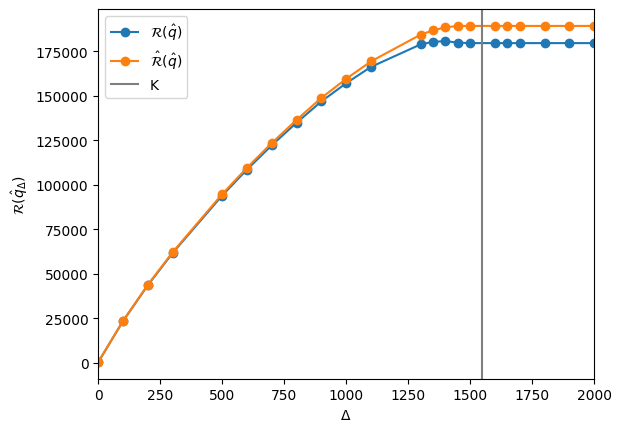

In [ ]:
plt.plot(delta_list, rev_list, linestyle='-', marker='o', label=r'${\mathcal{R}}(\hat{q})$')
plt.plot(delta_list, rev_approx_list, linestyle='-', marker='o', label=r'$\hat{\mathcal{R}}(\hat{q})$')
plt.axvline(x=param['m'], label='K', color='tab:gray')
plt.ylabel(r"$\mathcal{R}(\hat{q}_\Delta)$")
plt.xlabel(r'$\Delta$')
plt.xlim([0,max(delta_list)])
plt.legend()

#### Limited Resource

In [ ]:
L = [i for i in range(1,param['n']+1)]
param_copy = param.copy()
solutions = []
for i in range(11):
  param_copy['delta'] = param['m'] + 50 * i
  for iter in range(10):
    try:
      rev, p_ij, a_ij, org_q, star, surplus_all = approx_model(param_copy, solver='ipopt')
      solutions.append({'rev': rev, 'star': star, 'p_ij': p_ij, 'a_ij': a_ij, 'org_q': org_q, 'surplus_all': surplus_all})
    except:
      pass

best_solution = max(solutions, key=lambda sol: sol['rev']['lb'])
rev = best_solution['rev']
print(rev)

{'ub': np.float64(189245.13469077356), 'lb': np.float64(179586.67750097028)}


In [ ]:
file_path = os.path.join(dir_path, f'vanilla_units_{m}.pkl')
with open(file_path, 'wb') as file:
    pickle.dump(best_solution, file)

In [ ]:
m = param['m']
file_path = os.path.join(dir_path, f'vanilla_units_{m}.pkl')
with open(file_path, 'rb') as file:
    best_solution = pickle.load(file)

org_q = best_solution['org_q']
pi = best_solution['surplus_all']['r']

market, n, m, t = param['market'], param['n'], param['m'], param['t']

c = (n-1)/(2*m) + 1/(2*(n+m))
L = sum([market[i,j] * org_q[i,j] for i in range(1,n+1) for j in range(1,n+1) if i != j])
mu = 1/sum([market[i,j] * org_q[i,j]/L * t[i,j] for i in range(1,n+1) for j in range(1,n+1) if i != j])
LB1 = m/(m+n-1+L/mu)
LB2 = (c+1)-np.sqrt((c+1)*(c+1)-1)
UB = m/(m+n-1)
print(pi[1], LB1, LB2, UB)

pi = get_pi_for_balanced(market, n, m, org_q, t)
print(pi[1])

0.9484517866734545 0.5135112268772247 0.9228150826434046 0.9942196531791907
0.9484517866734545


In [ ]:
print(sum([market[key]*org_q[key]*t[key] for key in market.keys() if key[0] != key[1]]))

1457.5397393037158


#### Analysis

In [ ]:
prices = {(i,j): p_ij[i,j] for i in range(1,n+1) for j in range(1,n+1) if i != j}
p_max = max(prices, key=p_ij.get)
p_min = min(prices, key=p_ij.get)
print('maximum price: %.3f from %s' %(max(prices.values()), str(p_max)))
print('minimum price: %.3f from %s' %(min(prices.values()), str(p_min)))
print('price gap', max(prices.values()) - min(prices.values()))

maximum price: 12.116 from (7, 6)
minimum price: 0.000 from (3, 2)
price gap 12.11629158030623


In [ ]:
import pandas as pd
uber = data['uber']
p_avg = pd.DataFrame([[sum(uber['prices_per_dist'][i,j])/len(uber['prices_per_dist'][i,j]) if i != j else 0 for j in range(1, n+1)] for i in range(1, n+1)])
p_avg.index = range(1, len(p_avg.index) + 1)
p_avg.columns = range(1, len(p_avg.columns) + 1)

print('max:', p_avg.max().max())
min_value = p_avg[p_avg != 0].min().min()
print('min:', min_value)

max: 12.393088892434383
min: 3.937515653251475


In [ ]:
# Convert the dictionary to a pandas DataFrame with values for diagonal elements
p_bar = pd.DataFrame([[p_ij[(i, j)] if i != j else 0 for j in range(1, n+1)] for i in range(1, n+1)])
p_bar.index = range(1, len(p_bar.index) + 1)
p_bar.columns = range(1, len(p_bar.columns) + 1)
print('max:', p_bar.max().max())
min_value = p_bar[p_bar != 0].min().min()
print('min:', min_value)

max: 12.11629158030623
min: 3.1879950799386934


In [ ]:
error = p_bar - p_avg
print(error.abs().sum().sum())
print('MSE', error.abs().sum().sum()/10/9)
print(error.sum().sum())

180.04613894708518
MSE 2.000512654967613
-168.75804455855996


In [ ]:
# MAPE
error = (p_bar - p_avg)/p_avg
print('MAPE', error.abs().sum().sum()/10/9)

MAPE 0.2529883536039733


In [ ]:
# wMAPE
num = (p_bar - p_avg)
denom = p_avg
print('WMAPE', num.abs().sum().sum()/denom.abs().sum().sum())

WMAPE 0.2607320083367128


In [ ]:
# wwMAPE
num = (p_bar - p_avg) * data['uber']['num']
denom = p_avg * data['uber']['num']
print('wwMAPE', num.abs().sum().sum()/denom.abs().sum().sum())

wwMAPE 0.2173432695874137


In [ ]:
# wwMAPE
num = (p_bar - p_avg) * data['uber']['num']
denom = data['uber']['num']
print('average error weighted by the number of trips', num.abs().sum().sum()/denom.abs().sum().sum())

average error weighted by the number of trips 1.9478230217158947


### Plots

In [ ]:
import geopandas as gpd
from matplotlib.colors import TwoSlopeNorm

In [ ]:
def create_legend(line_colors):
    fig, ax = plt.subplots()
    for i in range(len(line_colors)):
        ax.plot([], [], label=f'($\\cdot$, {i+1})', color=line_colors[i])
    ax.remove()
    return ax

def subplot_price(price_list, d):
    fig, axs = plt.subplots(2, 5)
    fig.set_figheight(7)
    fig.set_figwidth(24)

    plt.subplots_adjust(hspace=0.4)

    size = 20
    n_iter = len(total_surplus_list)
    iter_list = [i / (n_iter - 1) for i in range(n_iter)] if n_iter != 1 else [0]

    level = 0.8
    N = max(price_list[0].keys())[0]

    tableau_palette = mcolors.TABLEAU_COLORS
    line_colors = list(tableau_palette)

    for i in range(1, N + 1):
        row = (i - 1) // 5
        col = (i - 1) % 5
        for j in range(1, N + 1):
            if i == j:
                continue
            line_color = line_colors[j - 1]
            axs[row, col].plot(iter_list, [p[i, j] for p in price_list], linewidth=3.0, alpha=level, color=line_color)

        axs[row, col].set_xlim([0, 1])
        axs[row, col].grid()
        axs[row, col].set_title(f'Origin {i}')

    # Create the legend outside the subplots
    legend_ax = create_legend(line_colors)
    new_legend = legend_ax.legend(loc='upper center', fancybox=True, shadow=True)
    for line in new_legend.get_lines():
        line.set_linewidth(2)

    handles = [
    plt.Line2D([0], [0], color=line_colors[j], linewidth=3)
    for j in range(len(line_colors))
    ]

    labels = [f'(:,{j+1})' for j in range(len(line_colors))]

    for ax in axs.flat:
        ax.set(xlabel=r'$\alpha$')
        ax.xaxis.label.set_fontsize(18)

    fig.subplots_adjust(top=0.9)
    fig.legend(
        handles,
        labels,
        bbox_to_anchor=(0.5, 1.03),
        loc='upper center',
        ncol=10,
        prop={"size": 18}
    )

    plt.show()

In [ ]:
def draw_average(weighted_a, weighted_p, surplus_list, total_surplus_list):

  tableau_palette = mcolors.TABLEAU_COLORS
  line_colors = list(tableau_palette) + ['darkblue', 'rebeccapurple']
  n_iter = len(total_surplus_list)
  iter_list = [i/(n_iter-1) for i in range(n_iter)] if n_iter != 1 else [0]

  fig, axs = plt.subplots(1, 3)
  fig.set_figheight(3.5)
  fig.set_figwidth(24)

  L = [i for i in range(1,len(weighted_a))]
  for i in [1,6,2,7,3,8,4,9,5,10]:
    line_color = line_colors[i-1]
    level = 1
    axs[1].plot(iter_list, [a[i] for a in weighted_a], label=r'$\bar{A}_{%d}$' %(i), linewidth=3.0, alpha=level, color=line_color)
    axs[0].plot(iter_list, [p[i] for p in weighted_p], label=r'$\bar{p}_{%d}$' %(i), linewidth=3.0, alpha=level, color=line_color)
    sur_i = [sum([market[i,j] * sur[i,j] for j in L if i != j])/sum([market[i,j] for j in L if i != j]) for sur in surplus_list]
    axs[2].plot(iter_list, sur_i, label=r'$\bar{S}_{%d}$' %(i), linewidth=3.0, alpha=level, color=line_color)

  for k in range(3):
      axs[k].set_xlim([0, 1])
      axs[k].grid()

  for i in range(3):
    box = axs[i].get_position()
    axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), fancybox=True, shadow=True, ncol=5, prop={"size":14})

  for ax in axs.flat:
      ax.set(xlabel=r'$\alpha$')
      ax.xaxis.label.set_fontsize(28) #28

  plt.show()

In [ ]:
def draw_revenue(revenue_list, total_surplus_list, fairness='Access'):
  revenue_ub, revenue_lb = revenue_list['ub'], revenue_list['lb']
  alpha_list = [i/10 for i in range(11)]

  if fairness == 'Access':
    plt.plot(alpha_list, revenue_ub, 'r--', label =  r'$\mathcal{R}_{\alpha}^{ub}(q_{ALG})$')
  plt.plot(alpha_list, revenue_lb, 'r:', label =  r'$\mathcal{R}_{\alpha}^{lb}(q_{ALG})$')

  plt.plot(alpha_list, total_surplus_list, 'g--', label = r'$\mathcal{S}_{\alpha}^{ub}(q_{ALG})$')

  welfare_list = [(revenue_lb[i]+total_surplus_list[i]) for i in range(11)]
  plt.plot(alpha_list, welfare_list, 'b--', label = r'$\mathcal{W}_{\alpha}(q_{ALG})$')

  plt.legend(ncol=4, loc='lower center', bbox_to_anchor=(0.5, 1.05))
  plt.xlim(0,1)
  plt.grid()
  plt.xlabel(r'$\alpha$', size=18)
  plt.show()

In [ ]:
from google.colab import files
def draw_heatmap(weighted, target='surplus', _filename='figure'):

  pwd = '/content/drive/MyDrive/Colab_Notebooks/Fair Fares/Code_Final'
  file = os.path.join(pwd, 'taxi_zones.shp')
  df = gpd.read_file(file)
  df['Zone_ID'] = df.index + 1

  loc_1 = [128, 127, 243, 244, 120, 116, 152, 166]
  loc_2 = [42, 41, 74, 75]
  loc_3 = [24, 151, 238, 239, 143, 142, 43]
  loc_4 = [236, 263, 262, 237, 141, 140]
  loc_5 = [50, 48, 246, 68]
  loc_6 = [163, 230, 161, 162, 100, 186, 164, 90, 234]
  loc_7 = [229, 233, 170, 137, 107, 224]
  loc_8 = [158, 249, 113, 114, 125, 211, 144]
  loc_9 = [79, 4, 148, 232]
  loc_10 = [231, 45, 209, 13, 261, 87, 88, 12]
  loc = {1: loc_1, 2: loc_2, 3: loc_3, 4: loc_4, 5: loc_5, 6: loc_6, 7: loc_7, 8: loc_8, 9: loc_9, 10: loc_10}

  all_zones = []
  for i in range(1, len(loc.values())+1):
      all_zones += loc[i]

  filtered_df = df[df['Zone_ID'].isin(all_zones)].copy()
  filtered_df['loc'] = None

  for zone_id, locations in loc.items():
      filtered_df.loc[filtered_df['Zone_ID'].isin(locations), 'loc'] = zone_id

  if target == 'surplus':
    s0 = weighted['s_i'][0]
    s_i_list = weighted['s_i']
  elif target == 'price':
    s0 = weighted['p_i'][0]
    s_i_list = weighted['p_i']
  elif target == 'access':
    s0 = weighted['a_i'][0]
    s_i_list = weighted['a_i']
  vmin_global, vmax_global = 100, 0
  for i in range(1,len(s_i_list)):
    surplus = [(s_i_list[i][k]-s0[k])/s0[k]*100 for k in loc.keys()]
    vmin_global = min(vmin_global, min(surplus))
    vmax_global = max(vmax_global, max(surplus))

  print(vmin_global, vmax_global)
  cmap = plt.cm.RdYlGn
  ub, lb = -80, 80 #-max(-vmin_global, vmax_global), max(-vmin_global, vmax_global)
  norm = TwoSlopeNorm(vmin=ub, vcenter=0, vmax=lb)

  fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
  for i in range(1,len(s_i_list)):
    filtered_df['surplus'] = [(s_i_list[i][k]-s0[k])/s0[k]*100 for k in filtered_df['loc']]

    gdf = gpd.GeoDataFrame(filtered_df, geometry='geometry')
    if i % 2 == 1:
      continue
    ax = axes[int(i/2)-1]
    legend = True if i == len(s_i_list) else False
    gdf.plot(column='surplus', cmap=cmap, legend=legend, vmin=-ub, vmax=lb, ax=ax, norm=norm)
    ax.set_title(r"$\alpha = %.1f$" %(i/10), fontsize=16, y=0)
    ax.axis('off')

  cax = fig.add_axes([0.9, 0.15, 0.01, 0.7])  # [left, bottom, width, height]
  sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
  sm._A = []
  fig.colorbar(sm, cax=cax)

  plt.subplots_adjust(wspace=-0.2, hspace=-0.1)

  plt.savefig(_filename + '.pdf', format='pdf', bbox_inches='tight')
  files.download(_filename + '.pdf')
  plt.show()

In [ ]:
def draw_pi(pi_list):
    tableau_palette = list(mcolors.TABLEAU_COLORS.keys())
    line_colors = ['0'] + tableau_palette + ['darkblue', 'rebeccapurple']
    n = len(pi_list) - 1
    m = len(pi_list[0])
    color_map = {str(key): line_colors[key] for key in range(1, m + 1)}

    x = np.linspace(0, 1, n + 1)

    y = {str(key): np.zeros(n + 1) for key in reversed(pi_list[0].keys())}

    for i, dictionary in enumerate(pi_list):
        for key, value in dictionary.items():
            y[str(key)][i] = value

    cumulative_heights = {key: np.cumsum(y[key]) for key in y.keys()}

    fig, ax = plt.subplots()
    bottom = np.zeros(n + 1)

    for key in y.keys():
        ax.bar(x, y[key], bottom=bottom, label=key, width=1/(2*n), color=color_map[key])
        bottom += y[key]

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1.0, 0.5),
        fancybox=True, shadow=True, ncol=1, prop={"size": 14}
    )

    ax.set_xlabel(r'$\alpha$', size=18)

    plt.show()

In [ ]:
def top_surplus(surplus_list, k=5):
  surplus_0 = surplus_list[0]
  for i in range(1,11):
    alpha = i/10
    surplus_i = surplus_list[i]
    sur = {}
    for i in range(1,11):
      for j in range(1,11):
        if i == j:
          continue
        else:
          sur[i,j] = surplus_i[i,j] - surplus_0[i,j]

    print(f"alpha: {alpha}")

    # Get the top 5 keys
    sorted_dict = sorted(sur.items(), key=lambda item: item[1])
    top_k = [item[0] for item in sorted_dict[-k:]]
    for top in top_k:
      print((sur[top]-surplus_0[top])/surplus_0[top])

    # Get the bottom 5 keys
    print("="*20)
    bottom_k = [item[0] for item in sorted_dict[:k]]
    for bottom in bottom_k:
      print((sur[bottom]-surplus_0[bottom])/surplus_0[bottom])

    print(f"top {k}: {top_k}")
    print(f"bottom {k}: {top_k}")


  top_k_dict, top_value_dict, bottom_k_dict, bottom_value_dict = {}, {}, {}, {}
  for alpha in range(1, 11):
    surplus_i = surplus_list[alpha]
    sur = {}
    for i in range(1,11):
      for j in range(1,11):
        if i == j:
          continue
        else:
          sur[i,j] = (surplus_i[i,j] - surplus_0[i,j])/surplus_0[i,j]

    print(f"alpha: {alpha}")

    # Get the top 5 keys
    sorted_dict = sorted(sur.items(), key=lambda item: item[1])
    top_k = [item[0] for item in sorted_dict[-k:]]
    top_k.reverse()
    top_value = []
    for top in top_k:
      top_value.append(sur[top])

    # Get the bottom 5 keys
    print("="*20)
    bottom_k = [item[0] for item in sorted_dict[:k]]
    bottom_value = []
    for bottom in bottom_k:
      bottom_value.append(sur[bottom])
    top_k_dict[alpha] = top_k
    top_value_dict[alpha] = top_value
    bottom_k_dict[alpha] = bottom_k
    bottom_value_dict[alpha] = bottom_value

## Access Fair Heuristic

In [ ]:
def access_fair(param, M_star = None, alpha = 0, criteria = 'origin', solver = 'ipopt', T=120, resource_constraint=True):
  market, b, k, n, m, d, t = param['market'], param['b'], param['k'], param['n'], param['m'], param['d'], param['t']

  L = [i for i in range(1,n+1)]

  model = ConcreteModel()

  ### Define the decision
  model.q = Var(L, L, bounds=(0, 1))

  ### Step 3: Define Objective
  model.revenue = Objective(expr = sum([log(k[i,j]*(1-model.q[i,j])/model.q[i,j])/b[i,j]*market[i,j]*model.q[i,j]*d[i,j] for i in L for j in L if i != j]), sense=maximize)

  ### constraints
  model.c = ConstraintList()

  m_list = []
  for i in L:
    if criteria == 'origin':
      m_list.append(sum([market[i,j]*model.q[i,j] for j in L if i != j])/sum([market[i,j] for j in L if i!= j]))
    else:
      for j in L:
        if i != j:
          m_list.append(model.q[i,j])

  eps = 0 # 1e-3
  if alpha != None:
    for i in range(len(m_list)):
      for j in range(i+1, len(m_list)):
        model.c.add(m_list[i] - m_list[j] <= (1-alpha) * M_star + eps)
        model.c.add(m_list[j] - m_list[i] <= (1-alpha) * M_star + eps)

  if resource_constraint:
    model.c.add(sum([market[i,j]*model.q[i,j]*t[i,j] for i in L for j in L if i != j]) <= param['delta'])

  for i in L:
    model.c.add(sum([market[i,j]*model.q[i,j] for j in L if i != j]) == sum([market[k,i]*model.q[k,i] for k in L if k != i]))
    for j in L:
      if i != j:
        model.c.add(model.q[i,j] <= 1)
        model.c.add(model.q[i,j] >= 0)

  _solver = SolverFactory(solver)
  results = _solver.solve(model)

  org_q = {(i,j): model.q[i,j]() for i in L for j in L}
  rev, sur, price, access = true_value(param, org_q)
  price_all = [price[i,j] for i in L for j in L if i != j]
  access_all = [access[i,j] for i in L for j in L if i != j]
  p_star, a_star = max(price_all)-min(price_all), max(access_all)-min(access_all)
  star = {'p': p_star, 'a': a_star}

  return price, {'lb': rev, 'ub': model.revenue()}, sur, access

In [ ]:
def access_algorithm_simulator(param, criteria, num_iter=10, dir_path=dir_path, loaded=True):
  num_iter = min(10, num_iter)
  n, m = param['n'], param['m']
  file_path = os.path.join(dir_path, f'vanilla_units_{m}.pkl')
  if os.path.exists(file_path):
    with open(file_path, "rb") as f:
      best_solution = pickle.load(f)
  else:
    print('there is no vanilla model')

  rev, p_ij, a_ij, org_q, star, surplus_all = best_solution['rev'], best_solution['p_ij'], \
  best_solution['a_ij'], best_solution['org_q'], best_solution['star'], best_solution['surplus_all']

  a_star = star[f'a_{criteria}']
  print('gap of Access', a_star)
  opt_0, rev_0 = p_ij, rev

  print('vanilla model loaded')


  revenue_lb, revenue_ub, total_surplus_list, surplus_list, p_list, a_list, weighted_a, weighted_p, weighted_s = [], [], [], [], [], [], [], [], []
  pi_list = []
  alpha_list = [i/10 for i in range(0, 11)]
  c_alpha = (n+m-1)/m

  param_copy = param.copy()
  for a in alpha_list:
    start_time = time.time()
    print('alpha', a)

    if a != 0:
      file_path = os.path.join(dir_path, f'access_{criteria}_{a}_units_{m}.pkl')
      if loaded and os.path.exists(file_path):
        with open(file_path, "rb") as f:
          best_solution = pickle.load(f)
      else:
        solutions = []
        for _delta in [param['m'] + 50*i for i in range(11)]:
          param_copy['delta'] = _delta
          for iter in range(num_iter):
            try:
              p_ij, rev, surplus_all, a_ij = access_fair(param_copy, M_star = c_alpha * a_star, alpha = a, criteria='origin')
              solutions.append({'rev': rev, 'p_ij': p_ij, 'sur': surplus_all, 'a_ij': a_ij})
            except:
              pass
        best_solution = max(solutions, key=lambda sol: sol['rev']['lb'])

        if os.path.exists(file_path):
          with open(file_path, "rb") as f:
            load_f = pickle.load(f)
            loaded_rev = load_f['rev']
            if best_solution['rev']['lb'] > loaded_rev['lb']:
              with open(file_path, 'wb') as file:
                pickle.dump(best_solution, file)
        else:
          with open(file_path, 'wb') as file:
            pickle.dump(best_solution, file)

        p_ij = best_solution['p_ij']
        a_ij = best_solution['a_ij']
        surplus_all = best_solution['sur']
        rev = best_solution['rev']

    p_ij = best_solution['p_ij']
    a_ij = best_solution['a_ij']
    surplus_all = best_solution['sur'] if a != 0 else best_solution['surplus_all']
    rev = best_solution['rev']

    revenue_lb.append(rev['lb'])
    revenue_ub .append(rev['ub'])
    total_surplus_list.append(surplus_all['ts'])
    surplus_list.append(surplus_all['s'])
    p_list.append(p_ij)
    a_list.append(a_ij)
    pi_list.append(surplus_all['r'])

    L = [l for l in range(1,n+1)]
    a_i = {i: sum([market[i,j] * a_ij[i,j] for j in L if i != j])/sum([market[i,j] for j in L if i != j]) for i in L}
    weighted_a.append(a_i)
    p_i = {i: sum([market[i,j] * p_ij[i,j] for j in L if i != j])/sum([market[i,j] for j in L if i != j]) for i in L}
    weighted_p.append(p_i)
    s_i = {i: sum([market[i,j] * surplus_all['s'][i,j] for j in L if i != j])/sum([market[i,j] for j in L if i != j]) for i in L}
    weighted_s.append(s_i)

    end_time = time.time()
    elapsed_time = end_time - start_time

    print('revenue', rev)
    print('total surplus', surplus_all['ts'])
    print('access ratio', (max(a_i.values()) - min(a_i.values()))/a_star)
    print(f"Elapsed time: {elapsed_time/60:.2f} minutes")
    print('='*20)

  return {'lb': revenue_lb, 'ub': revenue_ub}, total_surplus_list, surplus_list, p_list, a_list, {'a_i': weighted_a, 'p_i': weighted_p, 's_i': weighted_s, 'pi': pi_list}

## Experiments: Origin-based Access Fairness

In [ ]:
revenue_list, total_surplus_list, surplus_list, p_list, a_list, weighted = access_algorithm_simulator(param, criteria = 'origin', num_iter = 200, dir_path=dir_path, loaded=False)

gap of Access 0.47459362025750207
vanilla model loaded
alpha 0.0
revenue {'ub': np.float64(189245.13469077356), 'lb': np.float64(179586.67750097028)}
total surplus 66192.85604895209
access ratio 1.0
Elapsed time: 0.00 minutes
alpha 0.1
revenue {'lb': np.float64(179541.19199920617), 'ub': np.float64(188559.14211992375)}
total surplus 64591.46745176204
access ratio 0.86147466885235
Elapsed time: 0.36 minutes
alpha 0.2
revenue {'lb': np.float64(179045.5497699105), 'ub': np.float64(187282.84918453818)}
total surplus 62763.591024341404
access ratio 0.7688424973545946
Elapsed time: 0.45 minutes
alpha 0.3
revenue {'lb': np.float64(177913.93408952272), 'ub': np.float64(185338.78777032922)}
total surplus 60928.97249045783
access ratio 0.6754917227580756
Elapsed time: 0.44 minutes
alpha 0.4
revenue {'lb': np.float64(176180.64565800075), 'ub': np.float64(182672.4453282768)}
total surplus 58523.628354218876
access ratio 0.5817072341160733
Elapsed time: 0.40 minutes
alpha 0.5
revenue {'lb': np.floa

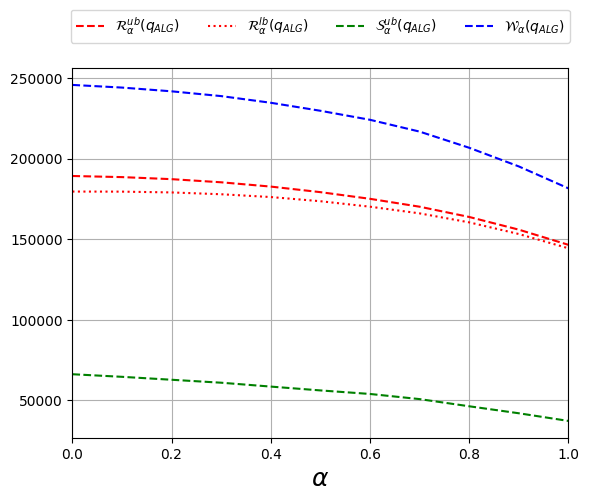

In [ ]:
draw_revenue(revenue_list, total_surplus_list, fairness='Access')

In [ ]:
revenue = revenue_list['lb']
tex = ''
for i in range(len(revenue)):
  t = str(round(revenue[i]/revenue[0]*100,2)) + '  '
  tex += '&~' + t
print(tex)

&~100.0  &~99.97  &~99.7  &~99.07  &~98.1  &~96.66  &~94.77  &~92.46  &~89.35  &~85.33  &~80.4  


In [ ]:
tex = ''
for i in range(len(total_surplus_list)):
  t = str(round(total_surplus_list[i]/total_surplus_list[0]*100,2)) + '  '
  tex += '&~' + t
print(tex)

&~100.0  &~97.58  &~94.82  &~92.05  &~88.41  &~84.82  &~81.5  &~76.68  &~69.96  &~63.4  &~56.22  


In [ ]:
tex = ''
welfare_list = [revenue[i]+total_surplus_list[i] for i in range(len(total_surplus_list))]
for i in range(len(welfare_list)):
  t = str(round(welfare_list[i]/welfare_list[0]*100,2)) + '  '
  tex += '&~' + t
print(tex)

&~100.0  &~99.33  &~98.38  &~97.18  &~95.49  &~93.47  &~91.2  &~88.21  &~84.13  &~79.42  &~73.89  


In [ ]:
param['m']

1548

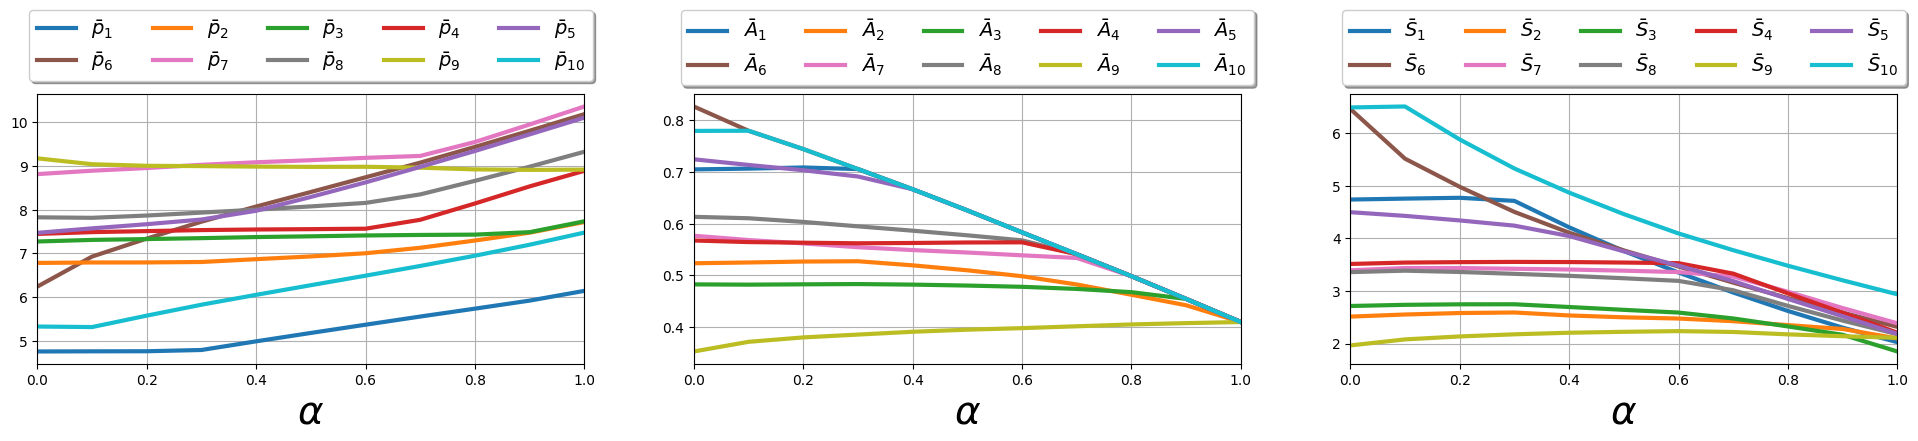

In [ ]:
draw_average(weighted['a_i'], weighted['p_i'], surplus_list, total_surplus_list)

-64.15447540368292 13.846734473796326


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

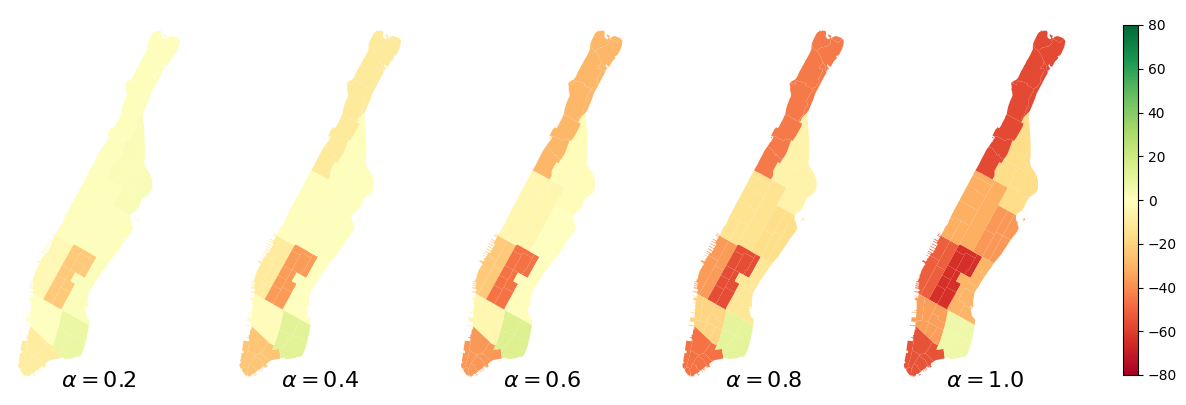

In [ ]:
# surplus
weighted_access = weighted
draw_heatmap(weighted_access, _filename = 'access_fair_case_study_weighted_surplus_7_9')

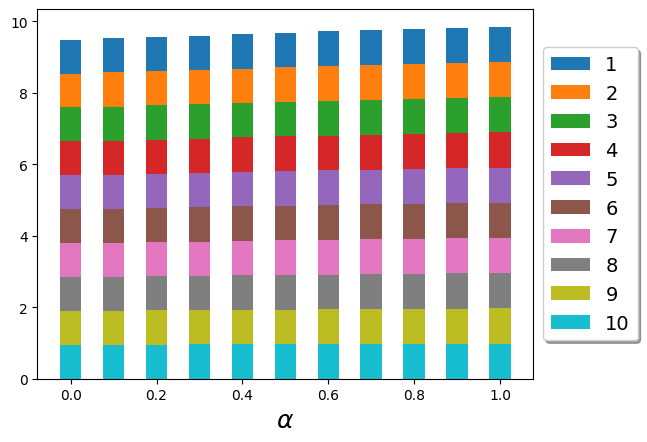

In [ ]:
draw_pi(weighted['pi'])

# Price Fair Heuristic

In [ ]:
def price_algorithm(param, price, alpha, num = 100):
  market, b, k, n, m, d, t = param['market'], param['b'], param['k'], param['n'], param['m'], param['d'], param['t']

  L = [i for i in range(1,n+1)]
  for i in L:
    if (i,i) in price.keys():
      del price[i,i]

  p_dict = {(i,j): price[i,j] for i in L for j in L if i != j}

  max_m = max(p_dict.values())
  min_m = min(p_dict.values())

  min_index = min(p_dict, key=p_dict.get)
  max_index = max(p_dict, key=p_dict.get)

  coeff = [0, 0.02, 0.04, 0.06, 0.08]
  width_list = [(1-alpha-c) * (max_m - min_m) for c in coeff] if alpha != 1 else [0]

  opt_obj = 0
  opt_sur = {'ts': 0, 's': {(i,j):0 for i in L for j in L}}
  opt_access = {(i,j): 0 for i in L for j in L}
  opt_p = {(i,j): 0 for i in L for j in L}

  step = (max_m - min_m) / num
  for width in width_list:
    bottom = max(min_m - width/2, 0)
    top = bottom + width
    while top <= max_m + width/2:
      p_dict_feasible = {}
      bottom_hit, top_hit = False, False
      for i in L:
        for j in L:
          if i == j:
            continue
          if p_dict[i,j] < bottom:
            p_dict_feasible[i,j] = bottom
            bottom_hit = True
          if p_dict[i,j] > top:
            p_dict_feasible[i,j] = top
            top_hit = True
          if p_dict[i,j] >= bottom and p_dict[i,j] <= top:
            p_dict_feasible[i,j] = p_dict[i,j]

      if bottom_hit and top_hit:
        pass
      elif bottom_hit:
        p_dict_feasible[max_index] = top
      elif top_hit:
        p_dict_feasible[min_index] = bottom

      p = {(i,j): p_dict_feasible[i,j] for i in L for j in L if i != j}
      q = {(i,j): k[i,j] * np.exp(-b[i,j] * p[i,j])/(1+k[i,j] * np.exp(-b[i,j] * p[i,j])) for i in L for j in L if i != j}
      q.update({(i,i): 0 for i in L})

      obj_alg, sur, _, access = true_value(param, q, balanced=False)

      if obj_alg > opt_obj and sum([market[i,j]*access[i,j]*t[i,j] for i in L for j in L if i != j]) <= m:
        opt_obj = obj_alg
        opt_p = p
        opt_sur = sur
        opt_access = access

      bottom, top = bottom + step, top + step

  return opt_p, opt_obj, opt_sur, opt_access

In [ ]:
import time

def price_algorithm_simulator(param, num=10, dir_path=dir_path, loaded=True, criteria='trip'):

  print('algorithm start')
  m = param['m']
  file_path = os.path.join(dir_path, f'vanilla_units_{m}.pkl')
  print(file_path)
  if os.path.exists(file_path):
    with open(file_path, "rb") as f:
      best_solution = pickle.load(f)
  else:
    print('there is no vanilla model')

  rev, opt_0, a_ij, org_q, star, surplus_all = best_solution['rev'], best_solution['p_ij'], \
  best_solution['a_ij'], best_solution['org_q'], best_solution['star'], best_solution['surplus_all']

  revenue_lb, revenue_ub, total_surplus_list, surplus_list, p_list, a_list, weighted_a, weighted_p, weighted_s = [], [], [], [], [], [], [], [], []
  pi_list = []
  prev_rev = 0
  alpha_list = reversed([i/10 for i in range(0, 11)])
  for a in alpha_list:
    start_time = time.time()
    print('alpha', a)
    file_path = os.path.join(dir_path, f'price_{criteria}_{a}_units_{m}.pkl')
    if loaded and os.path.exists(file_path):
      with open(file_path, "rb") as f:
        best_solution = pickle.load(f)
      p_ij, rev, surplus_all, a_ij = best_solution['p_ij'], best_solution['rev'], best_solution['sur'], best_solution['a_ij']
    elif a != 0:
      p_ij, rev, surplus_all, a_ij = price_algorithm(param, opt_0, a, num=num)
      best_solution = {'p_ij': p_ij, 'rev': rev, 'sur': surplus_all, 'a_ij': a_ij}
      if os.path.exists(file_path):
        with open(file_path, "rb") as f:
          load_f = pickle.load(f)
          loaded_rev = load_f['rev']
          if rev > loaded_rev:
            with open(file_path, 'wb') as file:
              pickle.dump(best_solution, file)
      else:
        with open(file_path, 'wb') as file:
          pickle.dump(best_solution, file)
    else:
      p_ij = opt_0

    if rev > prev_rev:
      revenue_lb = [rev] + revenue_lb
      revenue_ub = [rev] + revenue_ub
      total_surplus_list = [surplus_all['ts']] + total_surplus_list
      surplus_list = [surplus_all['s']] + surplus_list
      p_list = [p_ij] + p_list
      a_list = [a_ij] + a_list
      pi_list = [surplus_all['r']] + pi_list

      a_i = {i: sum([market[i,j] * a_ij[i,j] if i != j else 0 for j in L])/sum([market[i,j] if i != j else 0 for j in L]) for i in L}
      weighted_a = [a_i] + weighted_a
      p_i = {i: sum([market[i,j] * p_ij[i,j] if i != j else 0 for j in L])/sum([market[i,j] if i != j else 0 for j in L]) for i in L}
      weighted_p = [p_i] + weighted_p
      s_i = {i: sum([market[i,j] * surplus_all['s'][i,j] if i != j else 0 for j in L])/sum([market[i,j] if i != j else 0 for j in L]) for i in L}
      weighted_s = [s_i] + weighted_s
    else:
      revenue_lb = [revenue_lb[0]] + revenue_lb
      revenue_ub = [revenue_ub[0]] + revenue_ub
      total_surplus_list = [total_surplus_list[0]] + total_surplus_list
      surplus_list = [surplus_list[0]] + surplus_list
      p_list = [p_list[0]] + p_list
      a_list = [a_list[0]] + a_list
      pi_list = [pi_list[0]] + pi_list

      a_i = {i: sum([market[i,j] * a_ij[i,j] if i != j else 0 for j in L])/sum([market[i,j] if i != j else 0 for j in L]) for i in L}
      weighted_a = [weighted_a[0]] + weighted_a
      p_i = {i: sum([market[i,j] * p_ij[i,j] if i != j else 0 for j in L])/sum([market[i,j] if i != j else 0 for j in L]) for i in L}
      weighted_p = [weighted_p[0]] + weighted_p
      s_i = {i: sum([market[i,j] * surplus_all['s'][i,j] if i != j else 0 for j in L])/sum([market[i,j] if i != j else 0 for j in L]) for i in L}
      weighted_s = [weighted_s[0]] + weighted_s

    prev_rev = rev

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time/60:.2f} minutes")

  return {'lb': revenue_lb, 'ub': revenue_ub}, total_surplus_list, surplus_list, p_list, a_list, {'a_i': weighted_a, 'p_i': weighted_p, 's_i': weighted_s, 'pi': pi_list}

## Experiments: Trip-based Price Fairness

In [ ]:
revenue_list, total_surplus_list, surplus_list, p_list, a_list, weighted = price_algorithm_simulator(param, num=200, dir_path=dir_path, loaded=True)

algorithm start
/content/drive/MyDrive/Colab_Notebooks/Fair Fares/Code_Final/save_20230303_7_9_200/vanilla_units_1548.pkl
alpha 1.0
Elapsed time: 0.00 minutes
alpha 0.9
Elapsed time: 0.00 minutes
alpha 0.8
Elapsed time: 0.00 minutes
alpha 0.7
Elapsed time: 0.00 minutes
alpha 0.6
Elapsed time: 0.00 minutes
alpha 0.5
Elapsed time: 0.00 minutes
alpha 0.4
Elapsed time: 30.47 minutes
alpha 0.3
Elapsed time: 28.26 minutes
alpha 0.2
Elapsed time: 26.19 minutes
alpha 0.1
Elapsed time: 24.07 minutes
alpha 0.0
Elapsed time: 0.00 minutes


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os

def draw_origin_heatmap_absolute(ppm, origin, reversed = False):
    custom_green = (0, 1, 0)
    cmap = mcolors.LinearSegmentedColormap.from_list('custom_colormap', [(0, 'white'), (1, custom_green)])

    # candidate 1
    cmap = plt.cm.get_cmap('RdYlGn_r')
    if reversed:
      cmap = cmap.reversed()

    pwd = '/content/drive/MyDrive/Colab Notebooks/Fair Fares/Operatsions_Research/Case_Study'
    file = os.path.join(pwd, 'taxi_zones.shp')
    df = gpd.read_file(file)
    df['Zone_ID'] = df.index + 1

    loc_1 = [128, 127, 243, 244, 120, 116, 152, 166]
    loc_2 = [42, 41, 74, 75]
    loc_3 = [24, 151, 238, 239, 143, 142, 43]
    loc_4 = [236, 263, 262, 237, 141, 140]
    loc_5 = [50, 48, 246, 68]
    loc_6 = [163, 230, 161, 162, 100, 186, 164, 90, 234]
    loc_7 = [229, 233, 170, 137, 107, 224]
    loc_8 = [158, 249, 113, 114, 125, 211, 144]
    loc_9 = [79, 4, 148, 232]
    loc_10 = [231, 45, 209, 13, 261, 87, 88, 12]
    loc = {1: loc_1, 2: loc_2, 3: loc_3, 4: loc_4, 5: loc_5, 6: loc_6, 7: loc_7, 8: loc_8, 9: loc_9, 10: loc_10}

    all_zones = []
    for i in range(1, len(loc.values()) + 1):
        all_zones += loc[i]

    filtered_df = df[df['Zone_ID'].isin(all_zones)].copy()
    filtered_df['loc'] = None

    for zone_id, locations in loc.items():
        filtered_df.loc[filtered_df['Zone_ID'].isin(locations), 'loc'] = zone_id

    s_i_list = []
    vmin_global, vmax_global = 100, 0
    for price in ppm:
      price = []
      for k in filtered_df['loc']:
          if origin != k:
              price.append(ppm[origin, k])
          else:
              price.append(0)
      s_i_list.append(price)
      vmin_global = min(vmin_global, min(price))
      vmax_global = max(vmax_global, max(price))

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
    for i in range(1,len(s_i_list)):
      filtered_df['surplus'] = [s_i_list[i][k] for k in filtered_df['loc']]

      gdf = gpd.GeoDataFrame(filtered_df, geometry='geometry')
      if i % 2 == 1:
        continue
      ax = axes[int(i/2)-1]
      legend = True if i == len(s_i_list) else False
      gdf.plot(column='surplus', cmap=cmap, legend=legend, vmin=vmin_global, vmax=vmax_global, ax=ax)
      ax.set_title(r"$\alpha = %.1f$" %(i/10), fontsize=16, y=0)
      ax.axis('off')

    cax = fig.add_axes([0.9, 0.15, 0.01, 0.7])  # [left, bottom, width, height]
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin_global, vmax=vmax_global))
    sm._A = []
    fig.colorbar(sm, cax=cax)

    plt.subplots_adjust(wspace=-0.2, hspace=-0.1)


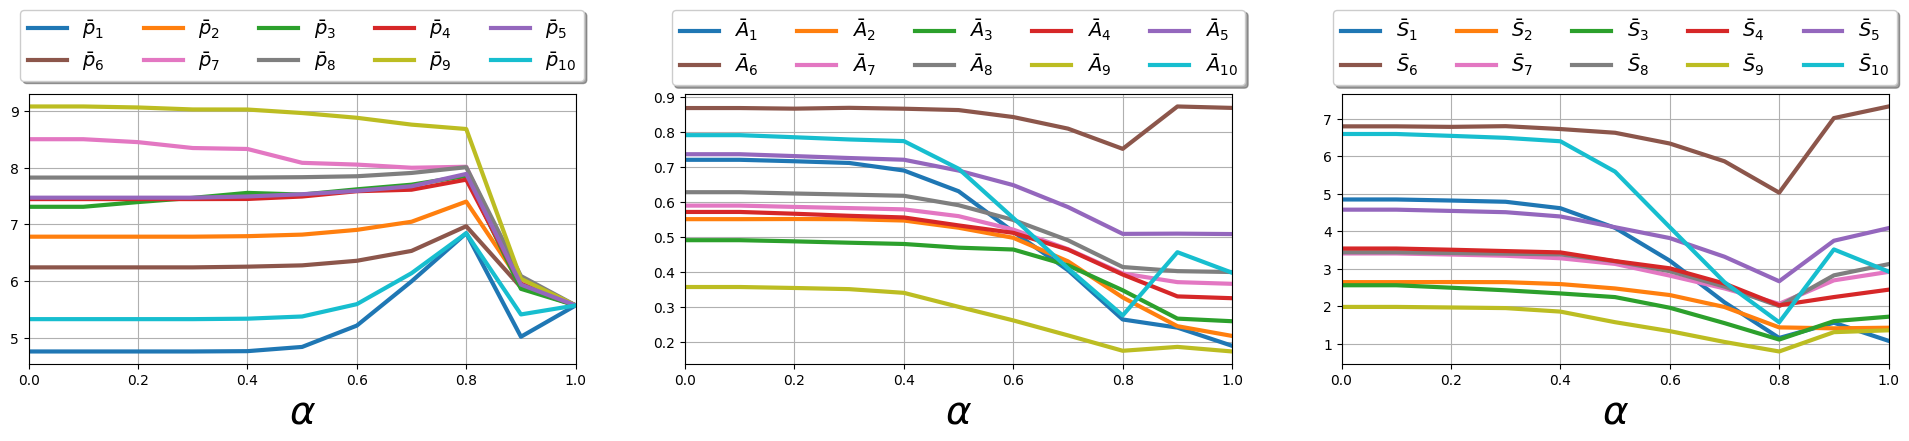

In [ ]:
draw_average(weighted['a_i'], weighted['p_i'], surplus_list, total_surplus_list)

In [ ]:
revenue = revenue_list['lb']
tex = ''
for i in range(len(revenue)):
  t = str(round(revenue[i]/revenue[0]*100,2)) + '  '
  tex += '&' + t
print(tex)

&100.0  &100.0  &99.36  &98.67  &97.98  &93.19  &85.62  &75.71  &63.5  &53.48  &47.83  


In [ ]:
tex = ''
for i in range(len(total_surplus_list)):
  t = str(round(total_surplus_list[i]/total_surplus_list[0]*100,2)) + '  '
  tex += '&' + t
print(tex)

&100.0  &100.0  &99.24  &98.51  &96.66  &90.72  &81.35  &68.51  &53.42  &73.02  &75.79  


In [ ]:
tex = ''
welfare_list = [revenue[i]+total_surplus_list[i] for i in range(len(total_surplus_list))]
for i in range(len(welfare_list)):
  t = str(round(welfare_list[i]/welfare_list[0]*100,2)) + '  '
  tex += '&' + t
print(tex)

&100.0  &100.0  &99.32  &98.63  &97.63  &92.53  &84.47  &73.77  &60.79  &58.73  &55.35  


-77.6736023169641 7.7921019721583065


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

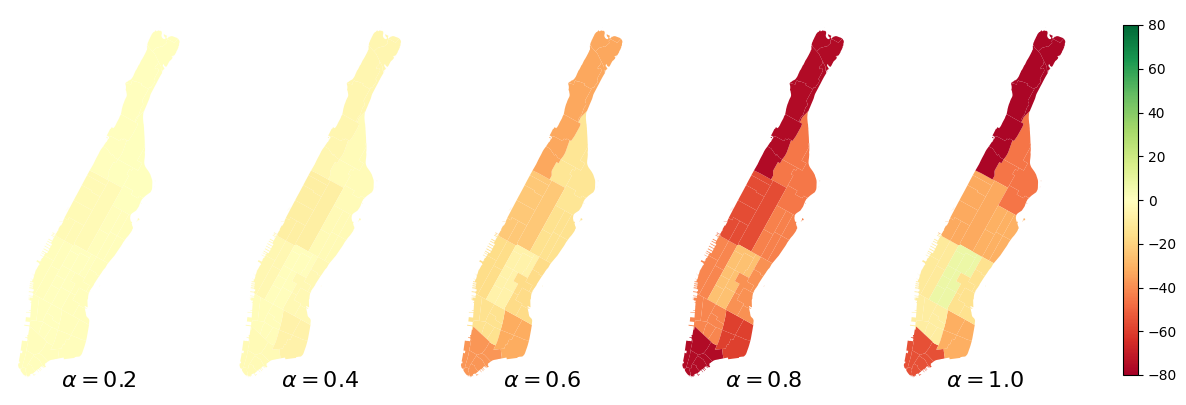

In [ ]:
weighted_price = weighted
draw_heatmap(weighted_price, _filename = 'price_fair_case_study_weighted_surplus_7_9')

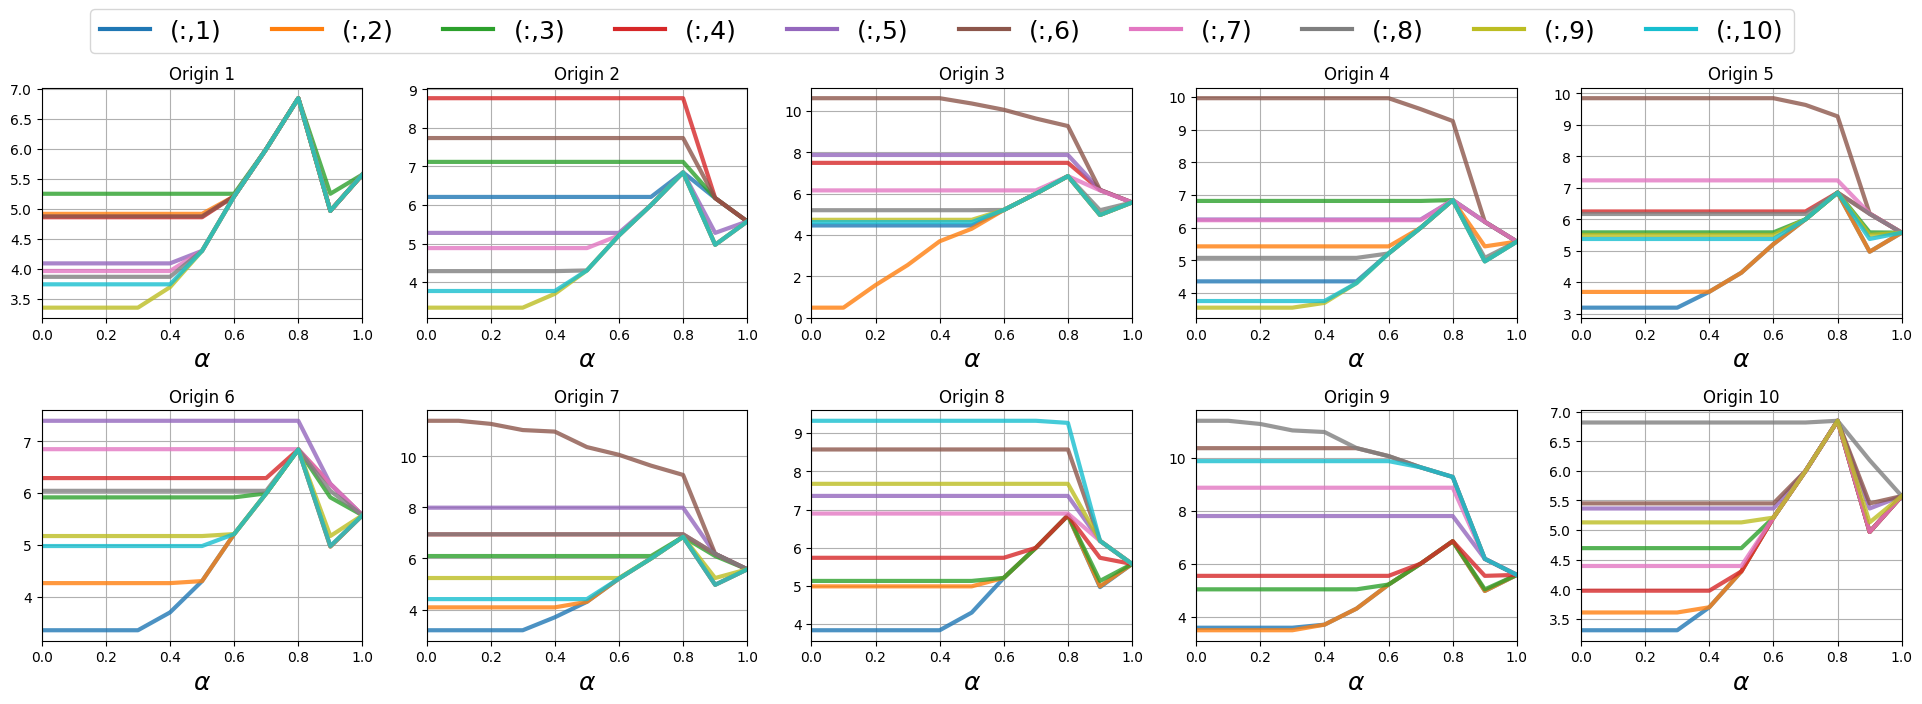

<Figure size 640x480 with 0 Axes>

In [ ]:
subplot_price(p_list, param['d'])

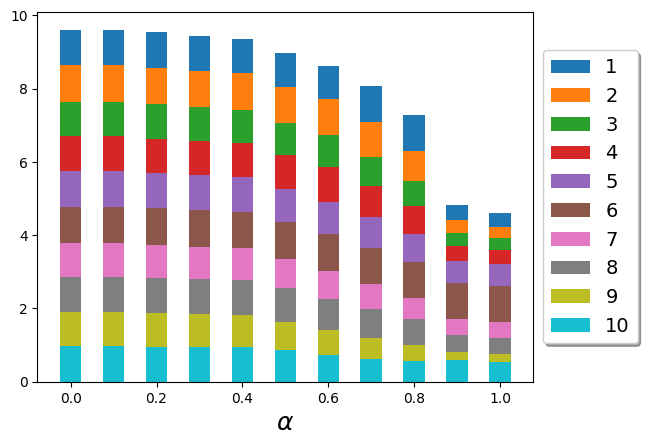

In [ ]:
draw_pi(weighted['pi'])